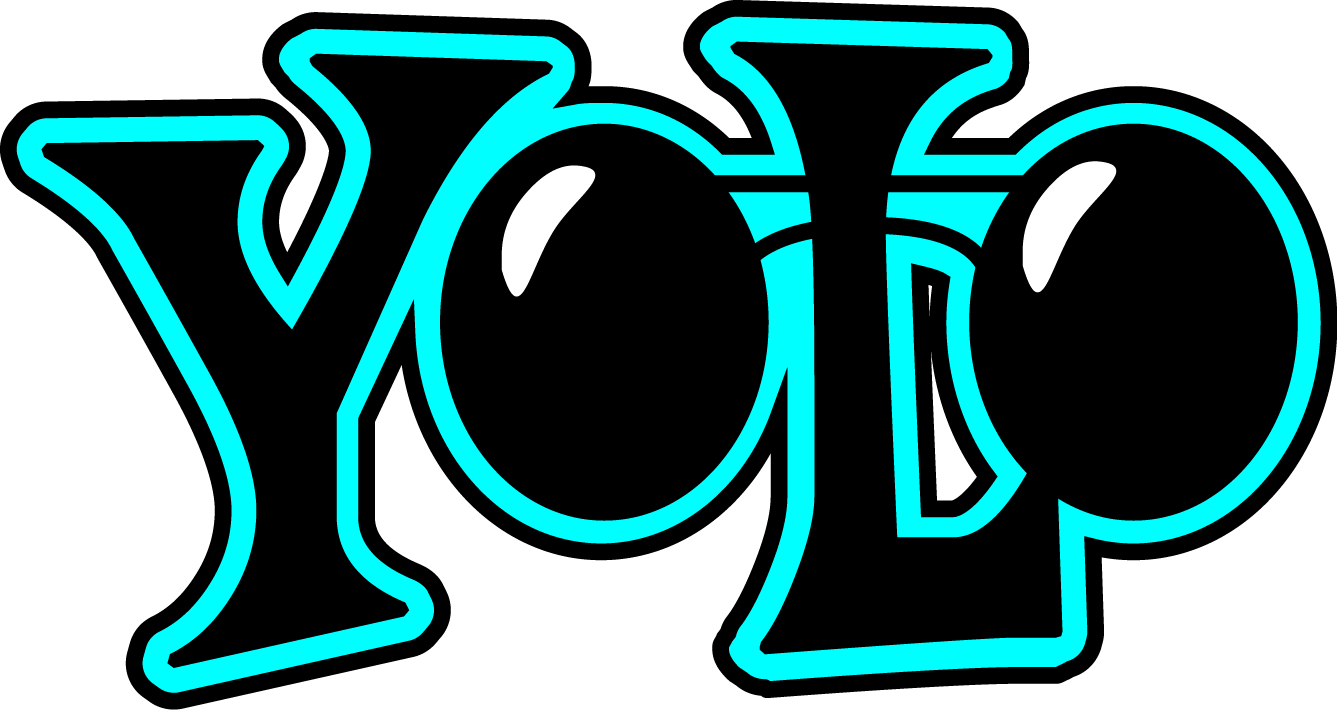

# Go through this https://arxiv.org/abs/1612.08242 for understanding YOLO better

In [ ]:
import ast
import os, cv2
from skimage import io
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
train = pd.read_csv('/kaggle/input/global-wheat-detection/train.csv')
train['image_id'] = train['image_id']+'.jpg'
train['bbox_'] = [ast.literal_eval(i) for i in train['bbox'].values.tolist()]
train = train.groupby('image_id')['bbox'].apply(list).reset_index(name='bbox')

In [ ]:
train.head(3)

In [ ]:
all_images=[]
for i in range(0,train.shape[0]):
    obj_l = []
    for z in train['bbox'][i]:
        z = ast.literal_eval(z)
        xym = {}
        xym['name'] = 'wheat'
        xym['xmin'] = z[0]
        xym['ymin'] = z[1]
        xym['xmax'] = z[2]+z[0]
        xym['ymax'] = z[3]+z[1]
        obj_l.append(xym)
    
    dicting = {}
    dicting['object'] = obj_l
    dicting['filename'] = '/kaggle/input/global-wheat-detection/train/'+train['image_id'][i]
    dicting['width'] = 1024
    dicting['height'] = 1024
    all_images.append(dicting)

In [ ]:
all_images[0]

In [ ]:

for i in all_images[:3]:
    path = i['filename']
    img = io.imread(path, plugin='matplotlib')
    for z in i['object']:
        cv2.rectangle(img, (int(z['xmin']), int(z['ymin'])), (int(z['xmax']), int(z['ymax'])), (0,255,255), 2)
    plt.figure(figsize=(15,10))
    plt.title('Image')
    plt.imshow(img)
    plt.show()
    

In [ ]:
LABELS = ['wheat']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 10
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0
BATCH_SIZE       = 16
WARM_UP_BATCHES  = 100
TRUE_BOX_BUFFER  = 50

In [ ]:
def IOU(ann, centroids):
    w, h = ann
    similarities = []

    for centroid in centroids:
        c_w, c_h = centroid

        if c_w >= w and c_h >= h:
            similarity = w*h/(c_w*c_h)
        elif c_w >= w and c_h <= h:
            similarity = w*c_h/(w*h + (c_w-w)*c_h)
        elif c_w <= w and c_h >= h:
            similarity = c_w*h/(w*h + c_w*(c_h-h))
        else: #means both w,h are bigger than c_w and c_h respectively
            similarity = (c_w*c_h)/(w*h)
        similarities.append(similarity) # will become (k,) shape

    return np.array(similarities)

def avg_IOU(anns, centroids):
    n,d = anns.shape
    sum = 0.

    for i in range(anns.shape[0]):
        sum+= max(IOU(anns[i], centroids))

    return sum/n


def print_anchors(centroids):
    anchors = centroids.copy()

    widths = anchors[:, 0]
    sorted_indices = np.argsort(widths)

    r = "anchors: ["
    for i in sorted_indices[:-1]:
        r += '%0.2f,%0.2f, ' % (anchors[i,0], anchors[i,1])

    #there should not be comma after last anchor, that's why
    r += '%0.2f,%0.2f' % (anchors[sorted_indices[-1:],0], anchors[sorted_indices[-1:],1])
    r += "]"

    print(r)

def run_kmeans(ann_dims, anchor_num):
    ann_num = ann_dims.shape[0]
    iterations = 0
    prev_assignments = np.ones(ann_num)*(-1)
    iteration = 0
    old_distances = np.zeros((ann_num, anchor_num))

    indices = [random.randrange(ann_dims.shape[0]) for i in range(anchor_num)]
    centroids = ann_dims[indices]
    anchor_dim = ann_dims.shape[1]

    while True:
        distances = []
        iteration += 1
        for i in range(ann_num):
            d = 1 - IOU(ann_dims[i], centroids)
            distances.append(d)
        distances = np.array(distances) # distances.shape = (ann_num, anchor_num)

        print("iteration {}: dists = {}".format(iteration, np.sum(np.abs(old_distances-distances))))

        #assign samples to centroids
        assignments = np.argmin(distances,axis=1)

        if (assignments == prev_assignments).all() :
            return centroids

        #calculate new centroids
        centroid_sums=np.zeros((anchor_num, anchor_dim), np.float)
        for i in range(ann_num):
            centroid_sums[assignments[i]]+=ann_dims[i]
        for j in range(anchor_num):
            centroids[j] = centroid_sums[j]/(np.sum(assignments==j) + 1e-6)

        prev_assignments = assignments.copy()
        old_distances = distances.copy()

In [ ]:
import random
grid_w = IMAGE_W/32
grid_h = IMAGE_H/32

# run k_mean to find the anchors
annotation_dims = []
for image in all_images:
    cell_w = image['width']/grid_w
    cell_h = image['height']/grid_h

    for obj in image['object']:
        relative_w = (float(obj['xmax']) - float(obj['xmin']))/cell_w
        relatice_h = (float(obj["ymax"]) - float(obj['ymin']))/cell_h
        annotation_dims.append(tuple(map(float, (relative_w,relatice_h))))
        
annotation_dims = np.array(annotation_dims)
num_anchors=5
centroids = run_kmeans(annotation_dims, num_anchors)
print('centroids',centroids)
# write anchors to file
print('\naverage IOU for', num_anchors, 'anchors:', '%0.2f' % avg_IOU(annotation_dims, centroids))
print_anchors(centroids)


Go through this https://www.kaggle.com/ashoksrinivas/data-augmentation-data-generation-yolovii?scriptVersionId=33702717 for Data Augumentation & Data Generation process (Next STEP)